#### Get forecast using both STL and ARIMA; compare

In [12]:
from getDriver import getDriver
from config import getClient
import pandas as pd
import numpy  as np
import rpy2 as r
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
import matplotlib.pyplot as plt
import operator
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

TEST_WEEKS = 6

In [13]:
def getData():
    dataloc = getClient("MC")
    
    pkid = "MasterCard Titanium Credit Card	GG0000001166	Processed-Gross Domestic Cash Volume"
    tmp = pkid.split(sep="\t")
    
    country  = "United Arab Emirates"
    program  = tmp[0]
    customer = tmp[1]
    driver   = tmp[2]
    typ = "P"
    dates, amounts = getDriver([country, program, customer, driver], typ)
    
    # Create Train and Test sets
    train = {}
    test = {}
    train["Amount"] = amounts[:-TEST_WEEKS]
    test["Amount"]  = amounts[-TEST_WEEKS:]
    train["Dates"]  = dates[:-TEST_WEEKS]
    test["Dates"]   = dates[-TEST_WEEKS:]
    
    # Make sure splitting train & test didn't lose any data
    assert (amounts.sum() - train["Amount"].sum() - test["Amount"].sum() < 0.1 )
    return train, test, dates, amounts

In [14]:
# If you're forecasting for May, June and July in 2018 you need the seasonal
# adjustment for May, June and July in 2017. You get those by subtracting 12 
# from the seasonality index
# "dates" holds the months to be forecast. The index is the week number
def getSeasonality(dates, seasonality):
    vals = []
    for x in dates.index:
        vals.append(seasonality[x-12])
    return pd.Series(vals)

In [15]:
# Get seaonality and trend using R and "stl"
def decomposeSTL(series, frequency, s_window, log=False,  **kwargs):
    series = series.values
    df = pd.DataFrame()
    if log: series = series.pipe(np.log)
    s = [x for x in series]
    length = len(series)
    s = r.ts(s, frequency=frequency)
    decomposed = [x for x in r.stl(s, s_window, robust=True).rx2('time.series')]
    df['observed']  = series
    df['trend']     = decomposed[length:2*length]
    df['seasonal']  = decomposed[0:length]
    df['residuals'] = decomposed[2*length:3*length]
    return df

In [16]:
# Get the MAPE between the inputs
def getMAPE(compare, test):
    diff = np.abs(compare-test)
    MAPE = diff.values/test
    return MAPE.mean()

In [17]:
train, test, d, a  = getData()

'''plt.plot( a, color = "b", label="train")
plt.plot(train["Amount"]/1000, color = "b", label="train")
plt.plot(test["Amount"]/1000, color = "r", label="test")
plt.legend(loc='upper right')
plt.title("Raw data")
plt.show()'''

'plt.plot( a, color = "b", label="train")\nplt.plot(train["Amount"]/1000, color = "b", label="train")\nplt.plot(test["Amount"]/1000, color = "r", label="test")\nplt.legend(loc=\'upper right\')\nplt.title("Raw data")\nplt.show()'

In [18]:
# Run the R function "stl" to get the Seasonal component
# Then remove the seasonal to get the adjusted
R = decomposeSTL(train["Amount"], frequency=12, s_window="periodic")
Rseasonal = R["seasonal"]
Radjusted = train["Amount"] - Rseasonal

In [19]:
P = seasonal_decompose(train["Amount"], freq=12, model='additive')
Pseasonal = P.seasonal
Padjusted = train["Amount"] - Pseasonal

In [ ]:
'''plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train["Dates"], Rseasonal, label="STL in R")
plt.plot(train["Dates"], Pseasonal, label="Python")
plt.xticks(rotation=90)
plt.title("Comparison of Seasonality in R and python")
plt.legend(loc='upper right')
plt.show()'''

In [ ]:
'''plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train["Dates"], Radjusted, label="R")
plt.plot(train["Dates"], Padjusted, label="Python")
#plt.plot(train["Dates"], train["Amount"], label="original")
plt.xticks(rotation=90)
plt.title("Comparison of Adjusted in R and python")
plt.legend(loc='upper right')
plt.show()'''

In [20]:
def getARIMAForecast(series, weeks):
    model     = ARIMA(series, order=(0,1,1))
    model_fit = model.fit(disp=0)
    # print summary of fit model
    #print(model_fit.summary())
    # Default alpha (CI) is 5%
    fcast, stderr, CI = model_fit.forecast(steps=weeks)
    return fcast, stderr, CI

In [21]:
fcast, stderr, CI = getARIMAForecast(train["Amount"], 6)
# Get the seasonal adjustments for the matching week
seasonality = getSeasonality(test["Dates"], Rseasonal)

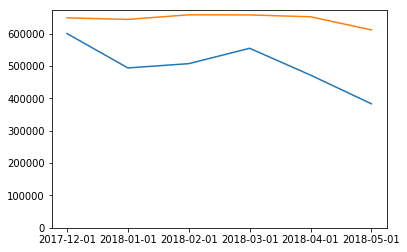

In [22]:
plt.plot(test["Dates"], fcast+seasonality, label="r")
plt.plot(test["Dates"], test["Amount"])
plt.ylim(0)
plt.show()

In [ ]:
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test["Dates"], fcast, label="fcast")
plt.plot(test["Dates"], CI, label="CI")
plt.xticks(rotation=90)
plt.title("Comparison of Seasonality in R and python")
plt.legend(loc='upper right')
plt.ylim(0)
plt.show()

In [ ]:
forecast = model_fit.forecast(steps=TEST_WEEKS)[0]
# Ensure "forecast" and "test" are for the same durations
assert (forecast.shape[0] == test.shape[0])
forecast += seasonal[-12:(-12+TEST_WEEKS)]

In [ ]:
fcastMAPE = getMAPE(forecast, test)
baseline  = np.array([train.iloc[-1]]*TEST_WEEKS)
baseMAPE  = getMAPE(baseline, test)
np.savetxt("/tmp/forecast.csv", forecast)
np.savetxt("/tmp/baseline.csv", baseline)
np.savetxt("/tmp/test.csv", test)
print("MAPE: {:.2%}".format(fcastMAPE))
print("MAPE: {:.2%}".format(baseMAPE))

In [ ]:
plt.plot(test.values, color="b")
plt.plot(forecast, color="r")
plt.show()

In [ ]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
import statsmodels.api as sm
lowest = 99999

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < lowest:
            lowest = results.aic
            save = (param, param_seasonal)
print('ARIMA{}x{}12 - AIC:{}'.format(save[0], save[1], lowest))

In [ ]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=save[0],
                                seasonal_order=save[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results=mod.fit()

In [ ]:
print(results.__doc__)

In [ ]:
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()